# Machine Temperature Dataset – Exploration

In this notebook, we conduct an exploratory analysis of the machine temperature dataset from the NAB (Numenta Anomaly Benchmark). The objective is to gain initial insights into the dataset structure and visualize patterns.

## Setup and Libraries
Importing necessary libraries and setting up configurations and data for the analysis.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# load data
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Load labeled anomaly windows from NAB
url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
response = requests.get(url)
labels = response.json()

# Extract windows for our dataset
label_key = "realKnownCause/machine_temperature_system_failure.csv"
anomaly_windows = [
    (pd.to_datetime(start), pd.to_datetime(end))
    for start, end in labels[label_key]
]

## Dataset Inspection
The following is an overview of the dataset to understand its basic structure, data types, and statistical characteristics.


In [3]:
print("Shape:", df.shape)
print('')
print('Head:')
print(df.head())
print('')
print('statistical summary:')
print(df.describe())


Shape: (22695, 1)

Head:
                         value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836

statistical summary:
              value
count  22695.000000
mean      85.926498
std       13.746912
min        2.084721
25%       83.080078
50%       89.408246
75%       94.016252
max      108.510543


In [10]:
intervals = df.index.to_series().diff().dropna()

most_common_interval = intervals.mode()[0]
print(f"Most common time interval: {most_common_interval}")

max_interval = df.index.to_series().diff().max()
print(f"Maximum time interval: {max_interval}")

Most common time interval: 0 days 00:05:00
Maximum time interval: 0 days 00:05:00


## Plot Time Series
This plot shows the machine temperature over time. It visualizes trends patterns, sudden shifts or spikes that may indicate abnormal behavior or system faults.

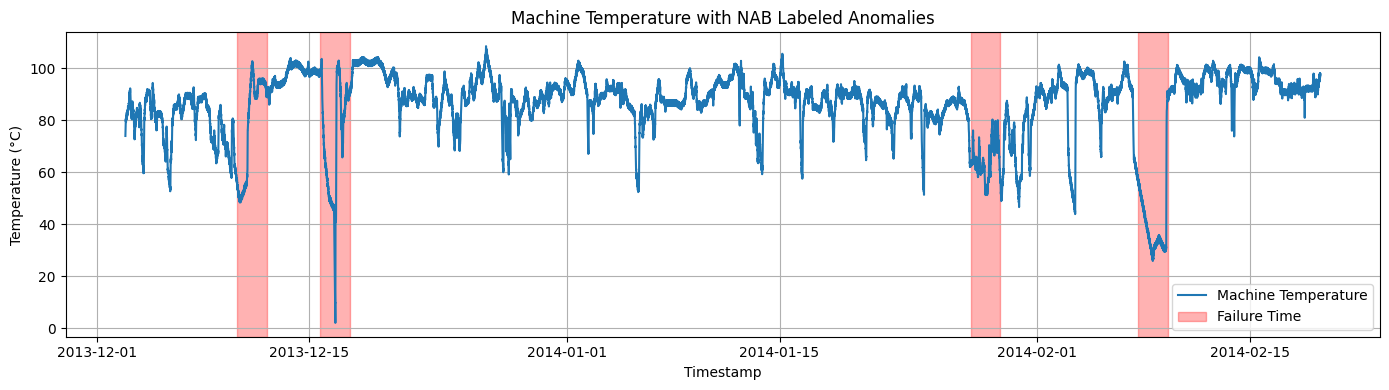

In [5]:
# Plot full series with anomaly windows shaded
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['value'], label='Machine Temperature')

for idx, (start, end) in enumerate(anomaly_windows):
    plt.axvspan(start, end, color='red', alpha=0.3,
               label='Failure Time' if idx == 0 else "_nolegend_")

plt.title("Machine Temperature with NAB Labeled Anomalies")
plt.ylabel("Temperature (°C)")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The temperature readings are generally stable but occasionally exhibit sudden, significant drops. The red-shaded intervals specifically indicate known system failure periods identified by the NAB dataset. Although some of these abrupt temperature decreases align with labeled failures, some notable drops occur outside these intervals. Such unlabeled drops may represent other equipment shutdowns or sensor faults.

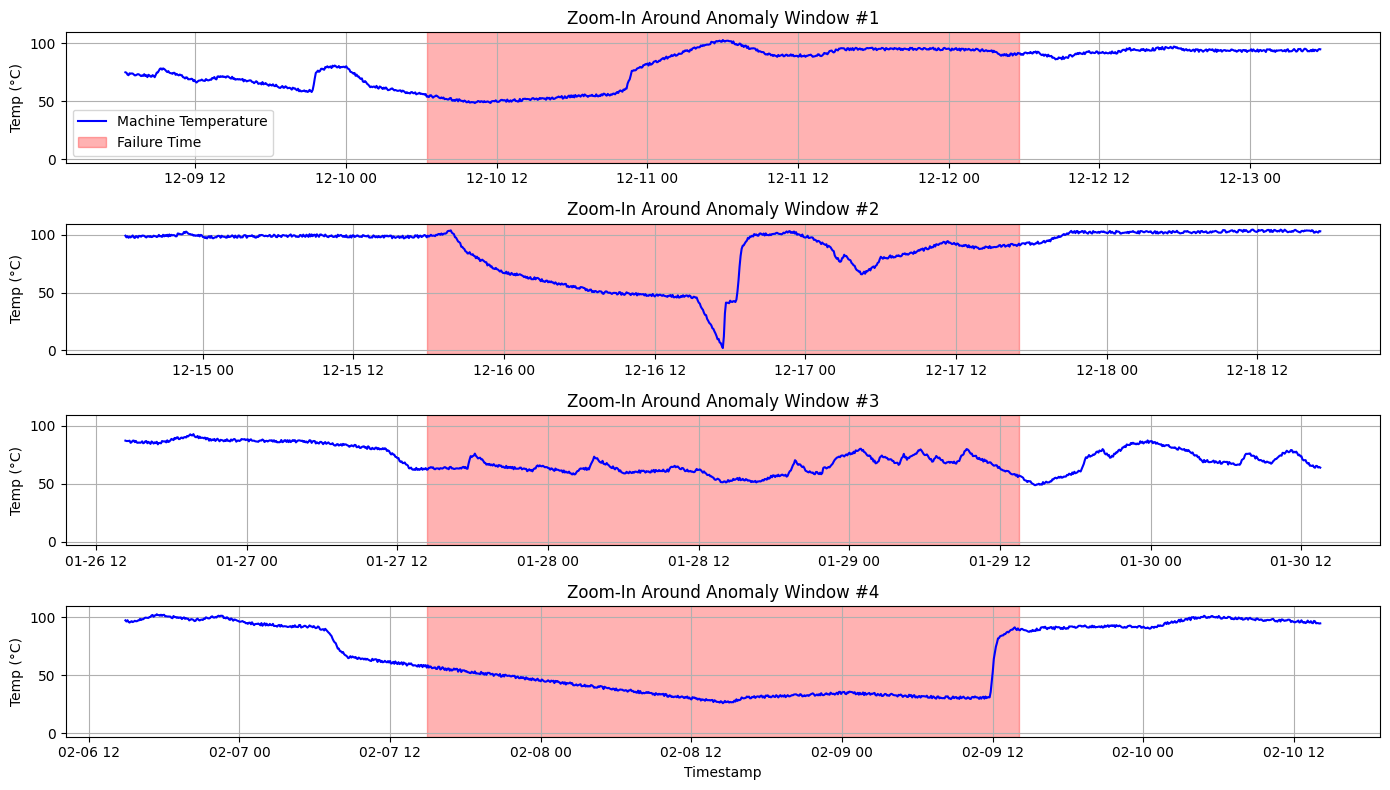

In [6]:

# Number of windows to plot (adjust if fewer than 4)
num_windows = len(anomaly_windows)

# Create subplots
fig, axes = plt.subplots(num_windows, 1, figsize=(14, 2 * num_windows), sharey=True)

for idx in range(num_windows):
    start, end = anomaly_windows[idx]
    zoom_start = start - timedelta(days=1)
    zoom_end = end + timedelta(days=1)
    df_zoom = df[(df.index >= zoom_start) & (df.index <= zoom_end)]

    ax = axes[idx]
    ax.plot(df_zoom.index, df_zoom['value'], color='blue', label='Machine Temperature')
    ax.axvspan(start, end, color='red', alpha=0.3, label='Failure Time')
    ax.set_title(f"Zoom-In Around Anomaly Window #{idx + 1}")
    ax.set_ylabel("Temp (°C)")
    ax.grid(True)
    if idx == num_windows - 1:
        ax.set_xlabel("Timestamp")
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()


## Temperature Distribution
This section explores the distribution of temperature readings during both normal operation and known failure periods.

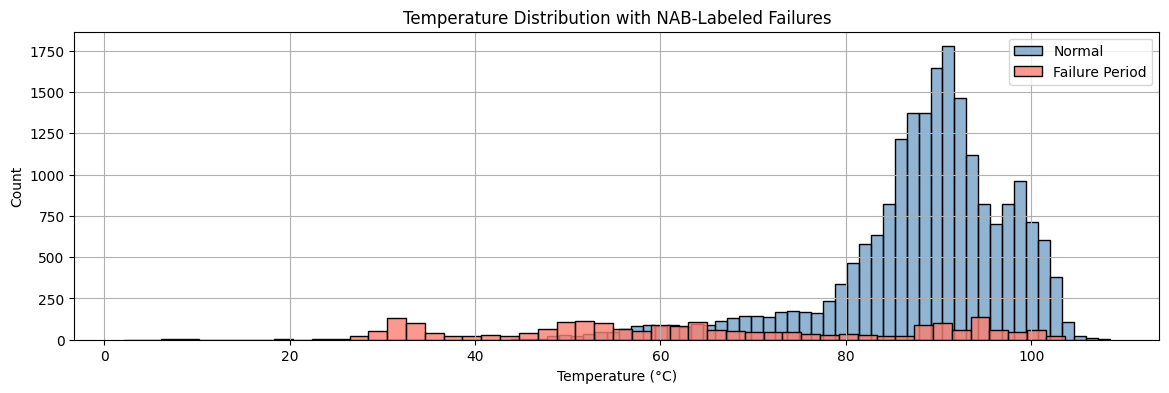

In [7]:
anomaly_values = pd.concat([
    df[(df.index >= pd.Timestamp(start)) & (df.index <= pd.Timestamp(end))]
    for start, end in anomaly_windows
])
normal_values = df.drop(anomaly_values.index)

plt.figure(figsize=(14, 4))
sns.histplot(normal_values['value'], bins=50, color='steelblue', alpha=0.6, label='Normal', kde=False)
sns.histplot(anomaly_values['value'], bins=50, color='salmon', alpha=0.8, label='Failure Period', kde=False)

plt.xlabel('Temperature (°C)')
plt.ylabel('Count')
plt.title('Temperature Distribution with NAB-Labeled Failures')
plt.legend()
plt.grid(True)
plt.show()


Normal readings (blue) dominate the histogram, with most values clustered between 80°C and 100°C. The overall distribution of temperature readings in normal conditon is left-skewed, with a noticeable tail toward lower temperatures. Some of these low-temperature readings during normal operation may indicate equipment shutdowns, startup phases, or sensor artifacts, and do not necessarily indicate system faults.
Failure-period readings (salmon) are concentrated more heavily in the lower temperature range, reflecting sudden drops commonly associated with known system failures.
However, there is significant overlap between normal and failure-period temperature values, indicating that temperature alone is not a sufficient indicator of failure. While many failures coincide with low-temperature readings, similar drops can also occur under normal conditions. 